In [307]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import dataset
from tqdm import tqdm

### Abstract
TODO

In [309]:
torch.__version__

'2.1.0.dev20230611'

### Load Dataset

In [310]:
quickdraw_dataset = dataset.QuickDrawDataset(root="/dataset", download=False)

[quickdraw dataset: root=/dataset, download=False]


Split dataset into train, validation, and test. The split is 80/10/10.

In [311]:
train_set, val_set, test_set = dataset.split(quickdraw_dataset)
len(train_set), len(val_set), len(test_set)

train_set, val_set, test_set = random_split(quickdraw_dataset, [0.1, 0.05, 0.85])
len(train_set), len(val_set), len(test_set)

(34500, 17250, 293250)

Create dataloaders for train, val, and test with a batch size of 128.

In [312]:
batch_size = 128

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Labels for Dataset

In [313]:
categories = dataset.QuickDrawDataset.categories()
num_categories = len(categories)
num_categories

345

### Visualize Dataset
See what different doodles look like.

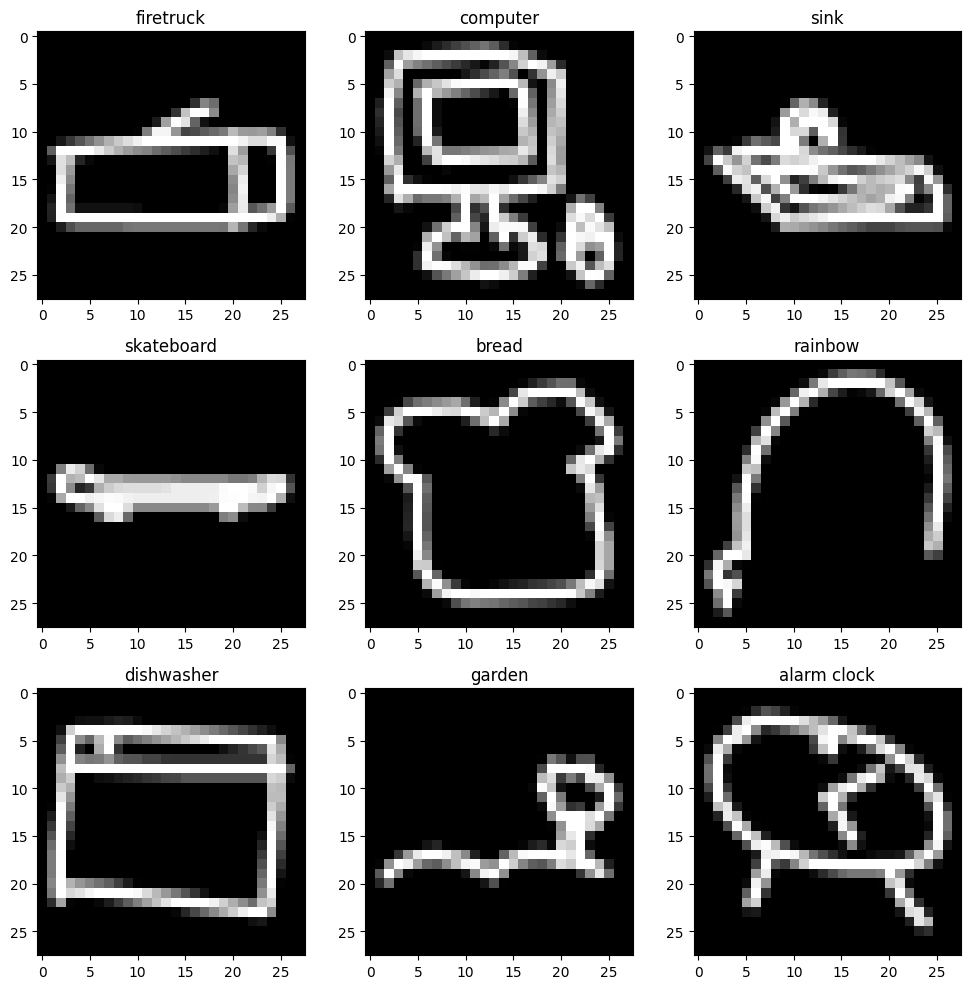

In [314]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
X, Y = test_set[:9]

for i, x in enumerate(X):
    y = Y[i]
    row, col = i // 3, i % 3
    
    # plot the image with its label
    category = categories[y]
    img = x[0]
    
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(category)
    
plt.tight_layout()

### Device
Use accelerated machine learning backend on Apple silicon if available

In [315]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

device

device(type='mps')

### Define Model
MiniAlexNet: TODO

In [336]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [337]:
minialexnet = MiniAlexNet(labels=num_categories).to(device)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (

### Define Loss & Optimizer

In [338]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [339]:
num_train_batches = len(train_dataloader)
num_train_batches

270

In [340]:
for x, y in train_dataloader:
    minialexnet(x.to(device))
    break

In [341]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [342]:
def accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    dataset_size = len(dataloader.dataset)
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            labels = torch.argmax(pred, dim=1)
            num_correct = (labels == Y.to(device)).sum().item()

            total_correct += num_correct
        
    return total_correct / dataset_size

In [343]:
def top_5_accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    dataset_size = len(dataloader.dataset)
    
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            pred = model(X)
            # Calculate top-5 predictions
            top5_values, top5_indices = torch.topk(pred, k=5, dim=1)

            # Check if true label is in top-5 predictions
            correct_top5 = torch.sum(top5_indices == Y.view(-1, 1), dim=1)

            # Count the number of correctly classified labels from top-5 predictions
            num_correct_top5 = torch.sum(correct_top5 == 1)

            total_correct += num_correct_top5.item()

    return total_correct / dataset_size

In [344]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    train_losses = []
    
    val_losses = []
    val_accuracies = []
    val_top5_accuracies = []
    
    print("Training")
    for epoch in range(epochs):
        # set mode to train
        model.train()
        
        total_loss = 0
        for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True, position=0)):
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
            
            # backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # average loss over batches
        train_loss = total_loss / len(train_dataloader)
        train_losses.append(train_loss)
        
        # evaluate model on validation set
        val_loss = evaluate(model, dataloader=val_dataloader, criterion=cross_entropy)
        val_losses.append(val_loss)
        val_accuracy = accuracy(model, val_dataloader)
        val_accuracies.append(val_accuracy)
        val_top5_accuracy = top_5_accuracy(model, val_dataloader)
        val_top5_accuracies.append(val_top5_accuracy)
        
#         print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss}, Val Loss: {val_loss} | Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val Top-5 Accuracy: {val_top5_accuracy}")

    return (train_losses, val_losses), (val_accuracies, val_top5_accuracies)

In [345]:
EPOCHS = 30
MODEL = minialexnet
CRITERION = cross_entropy
OPTIMIZER = optimizer
TRAIN = train_dataloader
VALIDATION = val_dataloader

losses, accuracies = train(model=MODEL, 
                                 criterion=CRITERION, 
                                 optimizer=OPTIMIZER, 
                                 train_dataloader=TRAIN, 
                                 val_dataloader=VALIDATION, 
                                 epochs=EPOCHS)

Training


Epoch 1 of 30: 100%|██████████████████████████| 270/270 [00:15<00:00, 17.96it/s]


Epoch [1/30], Loss: 5.847903952775178, Val Loss: 5.844057189093696, Val Accuracy: 0.0022028985507246378, Val Top-5 Accuracy: 0.013391304347826087


Epoch 2 of 30: 100%|██████████████████████████| 270/270 [00:16<00:00, 16.08it/s]


Epoch [2/30], Loss: 5.84236901777762, Val Loss: 5.844332129866989, Val Accuracy: 0.0023768115942028986, Val Top-5 Accuracy: 0.015594202898550725


Epoch 3 of 30: 100%|██████████████████████████| 270/270 [00:17<00:00, 15.82it/s]


Epoch [3/30], Loss: 5.699092571823686, Val Loss: 5.385967505419695, Val Accuracy: 0.01565217391304348, Val Top-5 Accuracy: 0.06823188405797101


Epoch 4 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.17it/s]


Epoch [4/30], Loss: 5.162324864776046, Val Loss: 4.80523290987368, Val Accuracy: 0.04643478260869565, Val Top-5 Accuracy: 0.17478260869565218


Epoch 5 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.23it/s]


Epoch [5/30], Loss: 4.647503902294018, Val Loss: 4.408179332591869, Val Accuracy: 0.08933333333333333, Val Top-5 Accuracy: 0.2733913043478261


Epoch 6 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.23it/s]


Epoch [6/30], Loss: 4.100719914612947, Val Loss: 3.6964068836636015, Val Accuracy: 0.18927536231884057, Val Top-5 Accuracy: 0.4518840579710145


Epoch 7 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.23it/s]


Epoch [7/30], Loss: 3.5626118977864585, Val Loss: 3.3489285398412636, Val Accuracy: 0.23866666666666667, Val Top-5 Accuracy: 0.5342028985507247


Epoch 8 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.19it/s]


Epoch [8/30], Loss: 3.2018453580361825, Val Loss: 3.1213080653437864, Val Accuracy: 0.28556521739130436, Val Top-5 Accuracy: 0.5849275362318841


Epoch 9 of 30: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.18it/s]


Epoch [9/30], Loss: 2.9197081795445197, Val Loss: 2.8563829369015163, Val Accuracy: 0.3344927536231884, Val Top-5 Accuracy: 0.6382608695652174


Epoch 10 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.23it/s]


Epoch [10/30], Loss: 2.71570986200262, Val Loss: 2.668597367957786, Val Accuracy: 0.3743768115942029, Val Top-5 Accuracy: 0.6756521739130434


Epoch 11 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.18it/s]


Epoch [11/30], Loss: 2.5514424606605814, Val Loss: 2.614559950651946, Val Accuracy: 0.3770434782608696, Val Top-5 Accuracy: 0.6874202898550724


Epoch 12 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.19it/s]


Epoch [12/30], Loss: 2.391688287699664, Val Loss: 2.549588750909876, Val Accuracy: 0.39895652173913043, Val Top-5 Accuracy: 0.6991304347826087


Epoch 13 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.16it/s]


Epoch [13/30], Loss: 2.243127867027565, Val Loss: 2.429921391275194, Val Accuracy: 0.4260289855072464, Val Top-5 Accuracy: 0.723072463768116


Epoch 14 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.19it/s]


Epoch [14/30], Loss: 2.11425147763005, Val Loss: 2.4021858347786798, Val Accuracy: 0.432, Val Top-5 Accuracy: 0.7325217391304348


Epoch 15 of 30: 100%|█████████████████████████| 270/270 [00:14<00:00, 18.25it/s]


Epoch [15/30], Loss: 2.0094245985702233, Val Loss: 2.3303964376449584, Val Accuracy: 0.44765217391304346, Val Top-5 Accuracy: 0.7419710144927536


Epoch 16 of 30:  64%|████████████████         | 174/270 [00:09<00:05, 18.07it/s]


KeyboardInterrupt: 

In [ ]:
train_losses, val_losses = losses

plt.plot(range(EPOCHS), train_losses)
plt.plot(range(EPOCHS), val_losses)

In [96]:
val_accuracies, val_top5_accuracies = accuracies

plt.plot(range(EPOCHS), train_accuracies)
plt.plot(range(EPOCHS), val_accuracies)

NameError: name 'accuracies' is not defined

### Evaluate Model on Test Set

In [10]:
torch.backends.mps.is_available()

True